# Beauty Wizard: *Cosmetic Ingredient Transparency & Risk Indicators*

This project analyzes multiple datasets of cosmetic products and their ingredients to improve ingredient transparency and identify potential safety and regulatory risk indicators. The data is cleaned, standardized, and integrated into a relational database to support reliable ingredient-level and product-level analysis.

The goal of this notebook is to examine how ingredients are used across products, brands, and categories, and to explore how formulation patterns relate to product rankings and external hazard or regulatory signals.

### Key questions:
- What are the most common ingredients across cosmetic products?
- Are certain ingredients associated with specific product types (e.g., moisturizers vs. treatments)?
- How many ingredients are typically used per product?
- Which brands and products rank highest in the dataset?
- Which ingredients appear in hazard or regulatory reporting sources?

### Approach:
To support these questions, multiple datasets are merged into a normalized SQLite database with enforced relationships between products, ingredients, hazard data, and chemical reports. Custom Python functions are used to automate data loading, ingredient normalization, and table linking, creating an analysis-ready foundation for further exploration and visualization.
This notebook queries and analyzes a pre-populated SQLite database created via external
schema and ETL scripts (iinstructions included in the README.md). All analysis below is performed against the normalized database.

## 1. Imports & Setup

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path

plt.rcParams['figure.figsize'] = (10,6)

## 2. Database Configuration and Raw Data Population

In [20]:
# DB config
DB_PATH = Path("db/BeautyWiz.db")
conn = sqlite3.connect(DB_PATH)

In [21]:
DATA = Path("data")

cosmetic = pd.read_csv(DATA / "cosmetic_p.csv")
beautyfeeds = pd.read_csv(DATA / "BeautyFeeds.csv")
chem = pd.read_csv(DATA / "cscpopendata.csv")

beautyfeeds.head()

,uniq_id,type,brand,name,price,ingredients
0,NaN,Sanitas Skincare Brightening Peel Pads (50 count),Sanitas Skincare,Sanitas Skincare Brightening Peel Pads (50 count),74.00,"Water, Alcohol, Glycolic Acid, Polysorbate 20,..."
1,NaN,Hair Treatment Oils,LIYALAN,LIYALAN Natural Pure Castor oil Cold Pressed U...,5.49,100% Sesamum Indicum (Sesame) Seed Oil
2,NaN,Shampoo & Conditioner,Bath & Body Works,Bath & Body Works Champagne Apple & Honey Sham...,NaN,NaN
3,NaN,NaN,Bed Head,Travel Size Hard Head Extreme Hold Hairspray,12.00,"Alcohol Denat., Isobutane, Dimethyl Ether, Oct..."
4,NaN,IMAGE Skincare ILUMA INTENSE BRIGHTENING EXFOL...,IMAGE Skincare,IMAGE Skincare ILUMA INTENSE BRIGHTENING EXFOL...,41.00,"Aqua/Water/Eau, Sodium Cocoyl Glycinate, Glyce..."


## 3. Data Cleaning & Preparation

Duplicate rows inspected and no changes needed:

In [22]:
# Check for duplicates
cosmetic.duplicated().sum()

np.int64(0)

Column normalization and type coercion were applied to support consistent downstream joins:

In [23]:
# Normalization for consistency
def normalize_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

cosmetic = normalize_columns(cosmetic)
beautyfeeds = normalize_columns(beautyfeeds)
chem = normalize_columns(chem)

cosmetic.head()

,label,brand,name,price,rank,ingredients,combination,dry,normal,oily,sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [24]:
cosmetic['price'] = pd.to_numeric(cosmetic['price'], errors='coerce')
cosmetic['rank'] = pd.to_numeric(cosmetic['rank'], errors='coerce')

cosmetic['price'] = cosmetic['price'].fillna(cosmetic['price'].median())
cosmetic['rank'] = cosmetic['rank'].fillna(cosmetic['rank'].median())

cosmetic.isna().sum()

label          0
brand          0
name           0
price          0
rank           0
ingredients    0
combination    0
dry            0
normal         0
oily           0
sensitive      0
dtype: int64

## 4. Exploratory Context (raw data)

This section provides high-level context on product pricing, rankings, and ingredientusage using the raw cosmetic dataset. These exploratory views help frame later database-driven analyses but are not used directly for conclusions.

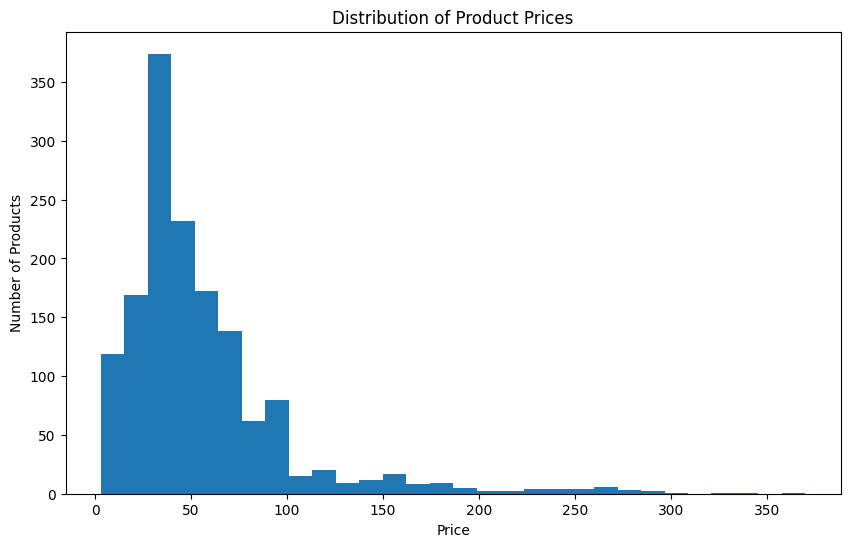

In [25]:
# Product price distribution

plt.hist(cosmetic['price'], bins=30)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Number of Products')
plt.show()

This distribution shows a strong skew, with most products clustered in lower price ranges (under $50) and a smaller number of luxury-priced outliers.

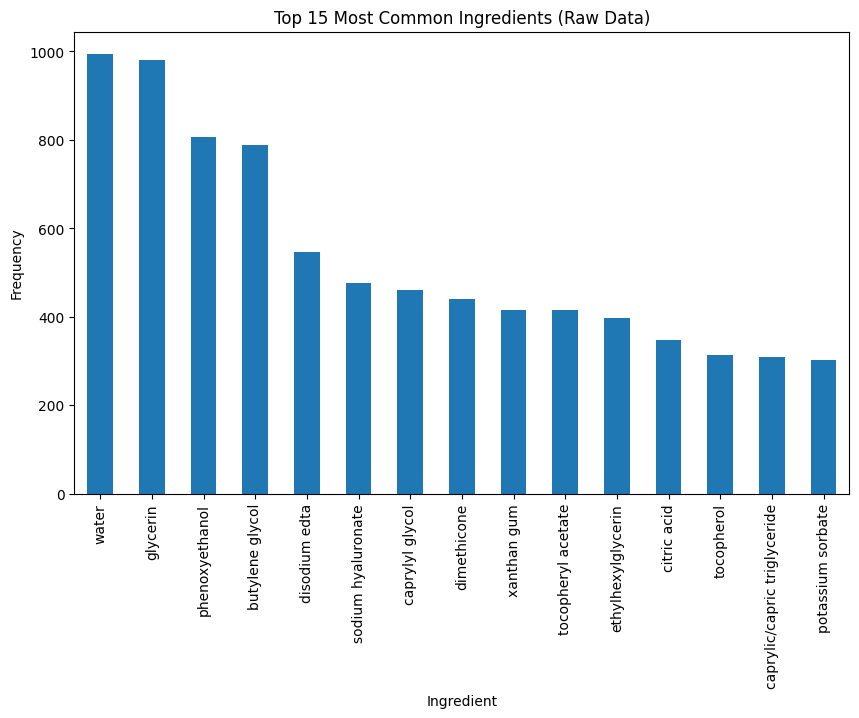

In [26]:
# Most common ingredients (raw frequency)

ingredients = (
    cosmetic["ingredients"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
    .str.lower()
)

top_ing = ingredients.value_counts().head(15)

top_ing.plot(kind="bar")
plt.title("Top 15 Most Common Ingredients (Raw Data)")
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.show()


A small number of ingredients appear repeatedly across products, suggesting a set of formulation staples that dominate cosmetic compositions.

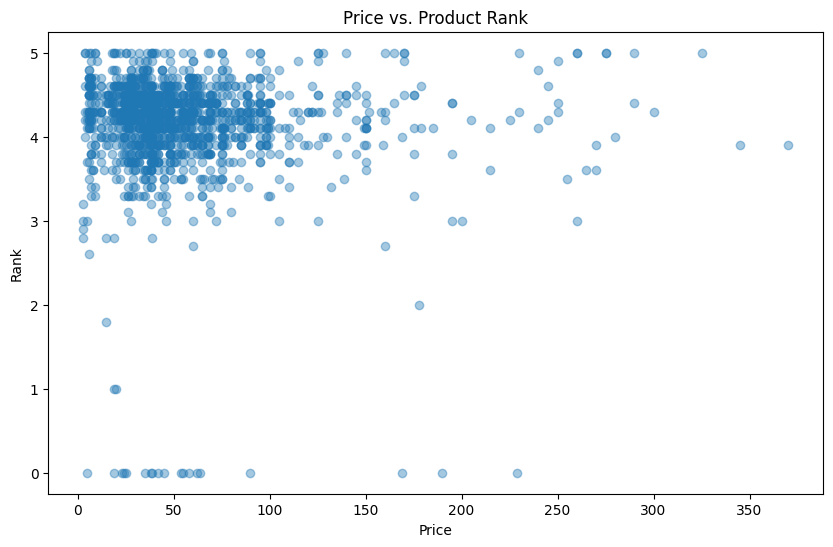

In [27]:
# Price vs. rank

plt.scatter(cosmetic['price'], cosmetic['rank'], alpha=0.4)
plt.title('Price vs. Product Rank')
plt.xlabel('Price')
plt.ylabel('Rank')
plt.show()

This scatter plot shows no strong linear relationship between price and ranking, suggesting that higher-priced products do not consistently receive better rankings.

These exploratory views provide descriptive context only. All subsequent analysis relies on the normalized SQLite database to ensure consistent relationships, aggregation, and reproducibility.

## 5. Database Design, Confirmation, and Connection

### Design Rationale

A relational schema was designed to model products, ingredients, and their many-to-many relationships. Separate tables for hazard and regulatory data allow external signals to be linked without duplicating product records.

An Entity-Relationship Diagram (ERD) was created to guide schema design.

Note: The BeautyWizard database schema and data population are handled by standalone scripts (`create_beautywiz_db.py` and `csv_import_sqlite.py`) executed prior to this notebook.
This notebook focuses exclusively on querying and analyzing the populated database.

In [28]:
conn = sqlite3.connect(DB_PATH)

pd.read_sql("PRAGMA database_list;", conn)


,seq,name,file
0,0,main,c:\Users\angel\beauty_wizard\db\BeautyWiz.db


In [29]:
pd.read_sql("""
SELECT name
FROM sqlite_master
WHERE type='table'
    AND name NOT LIKE 'sqlite_%';
""", conn)


,name
0,Products
1,Ingredients
2,ProductIngredients
3,IngredientHazards
4,ChemicalReports


In [30]:
pd.read_sql("""
SELECT 'Products' AS table_name, COUNT(*) AS row_count FROM Products
UNION ALL
SELECT 'Ingredients', COUNT(*) FROM Ingredients
UNION ALL
SELECT 'ProductIngredients', COUNT(*) FROM ProductIngredients
UNION ALL
SELECT 'IngredientHazards', COUNT(*) FROM IngredientHazards
UNION ALL
SELECT 'ChemicalReports', COUNT(*) FROM ChemicalReports;
""", conn)

,table_name,row_count
0,Products,13248
1,Ingredients,11254
2,ProductIngredients,404073
3,IngredientHazards,3876
4,ChemicalReports,229270


## 6. Querying BeautyWiz with SQL

### Query 1: Ingredient complexity by brand

Which brands tend to use more complex formulations (more ingredients per product)?

In [31]:
# Average ingredients per product by brand

conn = sqlite3.connect(DB_PATH)

query_brand_complexity = '''
SELECT
    p.brand,
    COUNT(DISTINCT pi.ingredient_id) * 1.0
        / COUNT(DISTINCT p.product_id) AS avg_ingredients_per_product,
    COUNT(DISTINCT p.product_id) AS product_count
FROM Products p
JOIN ProductIngredients pi
    ON p.product_id = pi.product_id
GROUP BY p.brand
HAVING COUNT(DISTINCT p.product_id) >= 5
ORDER BY avg_ingredients_per_product DESC;
'''

df_brand = pd.read_sql(query_brand_complexity, conn)
df_brand.shape

(116, 3)

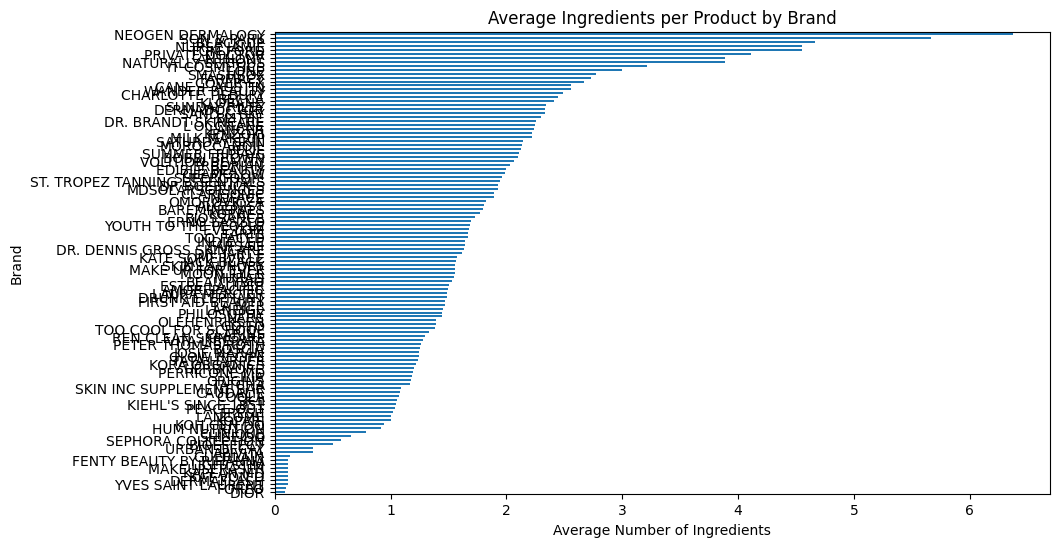

In [32]:
# Q1 Visualization

df_brand.sort_values("avg_ingredients_per_product").plot(
    kind="barh",
    x="brand",
    y="avg_ingredients_per_product",
    legend=False
)
plt.title("Average Ingredients per Product by Brand")
plt.xlabel("Average Number of Ingredients")
plt.ylabel("Brand")
plt.show()

This analysis compares average formulation complexity across brands by measuring the number of unique ingredients used per product. Brands with higher averages tend to produce more complex formulations.

### Query 2: Most Widely Used Ingredients Across Products

Which ingredients appear most frequently across cosmetic products?

In [33]:
# Ingredient prevalence

conn = sqlite3.connect(DB_PATH)

query_ingredients = '''
SELECT
    i.ingredient_name,
    COUNT(DISTINCT pi.product_id) AS product_count
FROM Ingredients i
JOIN ProductIngredients pi
    ON i.ingredient_id = pi.ingredient_id
GROUP BY i.ingredient_name
HAVING COUNT(DISTINCT pi.product_id) >= 20
ORDER BY product_count DESC
LIMIT 25;
'''

df_top_ingredients = pd.read_sql(query_ingredients, conn)
df_top_ingredients.shape


(25, 2)

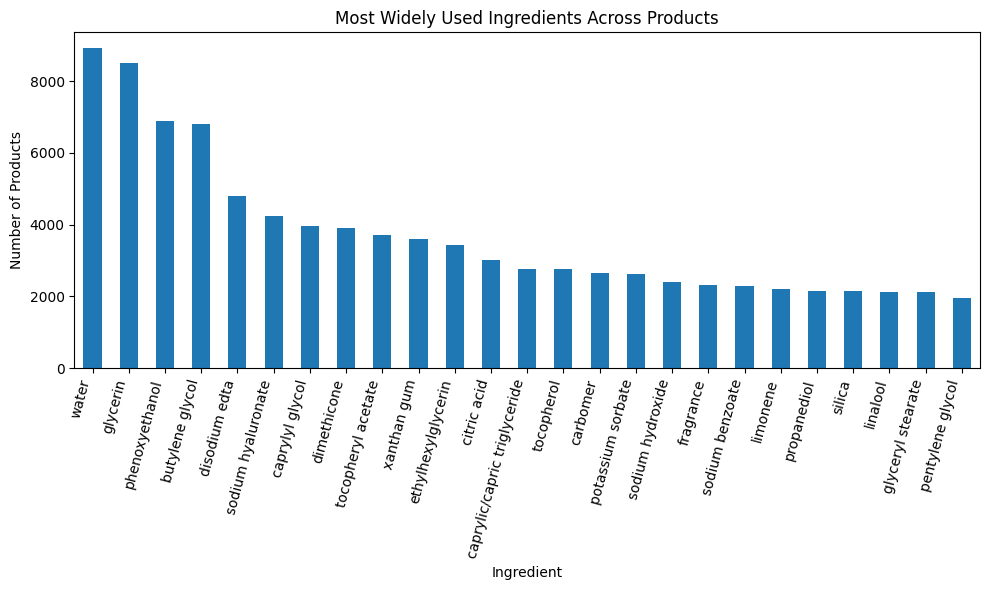

In [34]:
# Q2 Visualization

df_top_ingredients.plot(
    kind="bar",
    x="ingredient_name",
    y="product_count",
    legend=False
)
plt.title("Most Widely Used Ingredients Across Products")
plt.xlabel("Ingredient")
plt.ylabel("Number of Products")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


This query identifies ingredients that appear most frequently across cosmetic products, highlighting formulation staples that dominate product compositions.


### Query 3: Products with regulatory history

This query connects consumer products to chemical regulatory records, surfacing products that contain ingredients with documented reporting or discontinuation histories.

The resulting table provides ingredient-level transparency, while brand-level aggregation supports broader analysis of regulatory exposure across product lines.

**Visualization: Table + supporting bar chart, Primary: Clean, formatted table (brand, product, ingredient, report count), Secondary Bar chart: Count of regulated ingredients per brand, Why: Regulatory data is detail-oriented and best shown first in tabular form, Aggregated chart supports brand-level comparison*

In [35]:
# Products containing ingredients with chemical reporting records

conn = sqlite3.connect(DB_PATH)

query = """
WITH regulated_ingredients AS (
    SELECT
        ingredient_id,
        MAX(report_count) AS report_count,
        MAX(first_reported) AS first_reported,
        MAX(most_recent_report) AS most_recent_report,
        MAX(discontinued_date) AS discontinued_date
    FROM ChemicalReports
    WHERE report_count > 0
    GROUP BY ingredient_id
)
SELECT
    p.brand,
    p.product_name AS product,
    i.ingredient_name AS ingredient,
    r.first_reported,
    r.most_recent_report,
    r.discontinued_date,
    r.report_count
FROM regulated_ingredients r
JOIN Ingredients i
    ON r.ingredient_id = i.ingredient_id
JOIN ProductIngredients pi
    ON i.ingredient_id = pi.ingredient_id
JOIN Products p
    ON pi.product_id = p.product_id
ORDER BY r.report_count DESC
LIMIT 500;
"""

df_regulated_products = pd.read_sql(query, conn)
df_regulated_products.head()

,brand,product,ingredient,first_reported,most_recent_report,discontinued_date,report_count
0,TATCHA,The Water Cream,titanium dioxide,None,12/31/2019,12/31/2019,8
1,SUNDAY RILEY,Tidal Brightening Enzyme Water Cream,titanium dioxide,None,12/31/2019,12/31/2019,8
2,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,titanium dioxide,None,12/31/2019,12/31/2019,8
3,DR. JART+,Cicapair ™ Tiger Grass Color Correcting Treatm...,titanium dioxide,None,12/31/2019,12/31/2019,8
4,IT COSMETICS,Your Skin But Better™ CC+Illumination™ Cream w...,titanium dioxide,None,12/31/2019,12/31/2019,8


In [36]:
conn = sqlite3.connect(DB_PATH)

query = '''
WITH regulated_ingredients AS (
    SELECT
        ingredient_id,
        SUM(report_count) AS total_reports
    FROM ChemicalReports
    WHERE report_count > 0
    GROUP BY ingredient_id
)
SELECT
    p.brand,
    COUNT(DISTINCT r.ingredient_id) AS regulated_ingredient_count,
    SUM(r.total_reports) AS total_reports
FROM regulated_ingredients r
JOIN ProductIngredients pi
    ON r.ingredient_id = pi.ingredient_id
JOIN Products p
    ON pi.product_id = p.product_id
GROUP BY p.brand
ORDER BY total_reports DESC;
'''

df_regulated_products = pd.read_sql(query, conn)
df_regulated_products.head()

,brand,regulated_ingredient_count,total_reports
0,DR. JART+,5,17728416
1,SHISEIDO,7,11550114
2,PETER THOMAS ROTH,7,7674840
3,ALGENIST,7,6402294
4,AMOREPACIFIC,5,6046866


## 7. Conclusions

- A small number of ingredients dominate skincare formulations.
- Product price does not strictly correlate with ranking.
- SQLite enables reproducible, auditable analysis across datasets.

**Limitations:** Ingredient safety is inferred from reporting frequency, not medical evaluation.

**Next Steps:** Improve ingredient matching and expand regulatory datasets.